# Belgian rail data
The aim is to produce an isochrone map based on the GPTS data of the SNCB/NMBS of Belgium.

In [5]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from ipyleaflet import Map, Marker
from datetime import datetime
import networkx as nx
from pyvis.network import Network
import ipywidgets as widgets
import plotly.express as px

datadir = 'data/rail/'

In [3]:
os.listdir(datadir)

['dftime.csv',
 'gtfs-nmbs-2021-11-15',
 'gtfs-nmbs-2021-11-15.zip',
 'gtfs-nmbs-2021-11-19',
 'gtfs-nmbs-2021-11-20',
 'gtfs-nmbs-2021-11-21']

In [2]:
widgets.DatePicker(
    description='Pick a Date',
    disabled=False
)

DatePicker(value=None, description='Pick a Date')

In [8]:
# load data
#'https://gtfs.irail.be/nmbs/gtfs/'
fname = 'gtfs-nmbs-2021-11-19'
wd = datadir + fname + '/'
dftrips = pd.read_csv(wd + 'trips.txt')
dfcalendar = pd.read_csv(wd + 'calendar.txt')
dfstops = pd.read_csv(wd + 'stops.txt')
dfroutes = pd.read_csv(wd + 'routes.txt')
dfstoptime = pd.read_csv(wd + 'stop_times.txt')
dfstoptime['stop_id'] = dfstoptime['stop_id'].astype(str)
dftransfers = pd.read_csv(wd + 'transfers.txt')

In [7]:
dfstops.head()

,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,platform_code
0,0000252,NaN,Zwijndrecht-Dorp,NaN,51.219165,4.325671,NaN,NaN,0,NaN,NaN
1,8015345,NaN,Aachen Hbf (d),NaN,50.770830,6.105277,NaN,NaN,0,NaN,NaN
2,8200100,NaN,Luxembourg (l),NaN,49.600000,6.133333,NaN,NaN,0,NaN,NaN
3,8200102,NaN,Pfaffenthal-Kirchberg,NaN,49.619130,6.132853,NaN,NaN,0,NaN,NaN
4,8200110,NaN,Mersch (l),NaN,49.748890,6.106111,NaN,NaN,0,NaN,NaN


In [22]:
# map of stations (careful, this takes a lot of memory)
m = Map()
for i in range(dfstops.shape[0]):
    row = dfstops.loc[i, :]
    marker = Marker(location=(row['stop_lat'], row['stop_lon']), draggable=False, title=row['stop_name'])
    m.add_layer(marker)
m

Map(center=[0.0, 0.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

In [11]:
dftrips.head()

,route_id,service_id,trip_id,trip_headsign,trip_short_name,direction_id,block_id,shape_id,trip_type
0,1,1,88____:049::8885001:8885704:4:826:20211203,Mouscron,11000,NaN,1,NaN,1
1,1,1,88____:049::8885001:8885704:4:926:20211203,Mouscron,11001,NaN,2,NaN,1
2,1,1,88____:049::8885001:8885704:4:1026:20211203,Mouscron,11002,NaN,3,NaN,1
3,1,1,88____:049::8885001:8885704:4:1126:20211203,Mouscron,11003,NaN,4,NaN,1
4,2,2,88____:049::8892601:8895208:4:604:20211205,Zottegem,11003,NaN,5,NaN,1


In [149]:
dfstoptime.head()

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled
0,88____:049::8885001:8885704:4:826:20211203,07:29:00,07:29:00,8885001,1,NaN,0,1,NaN
1,88____:049::8885001:8885704:4:826:20211203,07:39:00,07:40:00,8885068,2,NaN,0,0,NaN
2,88____:049::8885001:8885704:4:826:20211203,08:09:00,08:10:00,8885753,3,NaN,0,0,NaN
3,88____:049::8885001:8885704:4:826:20211203,08:26:00,08:26:00,8885704,4,NaN,1,0,NaN
4,88____:049::8885001:8885704:4:926:20211203,08:29:00,08:29:00,8885001,1,NaN,0,1,NaN


In [14]:
dfroutes.head()

,route_id,agency_id,route_short_name,route_long_name,route_desc,route_type,route_url,route_color,route_text_color
0,1,NMBS/SNCB,BUS,Tournai -- Mouscron,NaN,700,NaN,NaN,NaN
1,10,NMBS/SNCB,BUS,Libramont -- Bertrix,NaN,700,NaN,NaN,NaN
2,100,NMBS/SNCB,IC,Ostende -- Gand-Saint-Pierre,NaN,103,NaN,NaN,NaN
3,101,NMBS/SNCB,L,Audenarde -- Renaix,NaN,100,NaN,NaN,NaN
4,102,NMBS/SNCB,IC,Bruxelles-Midi -- Rochefort-Jemelle,NaN,103,NaN,NaN,NaN


In [184]:
dftransfers.head()

,from_stop_id,to_stop_id,transfer_type,min_transfer_time,from_trip_id,to_trip_id
0,8015345,8015345,2,300,NaN,NaN
1,8200100,8200100,2,300,NaN,NaN
2,8200102,8200102,2,300,NaN,NaN
3,8200110,8200110,2,300,NaN,NaN
4,8200120,8200120,2,300,NaN,NaN


To know the path between A and B:
- get `stop_id` by looking for the stop names in the `dfstops`
- get `trip_id` that go by each stop in the `dfstoptime`
    - if both stops are on the same trip, then there is not connection
    - else we need to look for stop in common between the trips (works if only one connection), otherwise it's a multi-search problem...
- the trip can be related to the `route_id` to get more information about the routes in the `dftrips` and `dfroutes`

GTFS specification: https://gtfs.org/reference/static/

Question: how to make connection?

In [172]:
# query
locA = 'Gand-Saint-Pierre'
locB = 'Namur'

# search by keywords
dfstops[dfstops['stop_name'].str.contains('Gand')]['stop_name']

# get stopID for A and B
# location_type == 1 is a station (0 is just a stop, or a platform)
istation = dfstops['location_type'] == 1
stationA = dfstops[dfstops['stop_name'].eq(locA) & istation]['stop_id'].values[0]
stationB = dfstops[dfstops['stop_name'].eq(locB) & istation]['stop_id'].values[0]
print('station A:', stationA)
print('station B:', stationB)
# the stops give the platform number separated by underscore
stopsA = dfstops[dfstops['stop_name'].eq(locA) & ~istation]['stop_id'].tolist()
stopsB = dfstops[dfstops['stop_name'].eq(locB) & ~istation]['stop_id'].tolist()
print('stops A:', stopsA)
print('stops B:', stopsB)

# search for common trip_id
istop = dfstoptime['pickup_type'].eq(0) # other stops are passed but not called at
tripsA = dfstoptime[istop & (dfstoptime['stop_id'] == stationA[1:])]['trip_id'].drop_duplicates()
tripsB = dfstoptime[istop & (dfstoptime['stop_id'] == stationB[1:])]['trip_id'].drop_duplicates()
tripsInCommon = tripsA[tripsA.isin(tripsB.tolist())].tolist()
print(len(tripsInCommon))

# get trips information
itrip = dftrips['trip_id'].isin(tripsInCommon)
display(dftrips[itrip])

# get route information (note that same train can do multiple trips a day)
dfroutes[dfroutes['route_id'].isin(dftrips[itrip]['route_id'].tolist())]

# see if they are on the same route_id


station A: S8892007
station B: S8863008
stops A: ['8892007_8       ', '8892007_5       ', '8892007_9       ', '8892007_11      ', '8892007_10      ', '8892007_12      ', '8892007_1       ', '8892007_2       ', '8892007_3       ', '8892007_4       ', '8892007']
stops B: ['8863008_10      ', '8863008_9       ', '8863008_4       ', '8863008_5       ', '8863008_3       ', '8863008_7       ', '8863008_11      ', '8863008_6       ', '8863008_2       ', '8863008_8       ', '8863008']
9


,route_id,service_id,trip_id,trip_headsign,trip_short_name,direction_id,block_id,shape_id,trip_type
7783,226,203,88____:007::8891702:8866001:63:2122:20220828,Arlon,2118,NaN,6871,NaN,1
7802,226,321,88____:007::8891702:8866001:63:2222:20220827,Arlon,2119,NaN,6887,NaN,1
7803,226,322,88____:007::8891702:8866001:63:2222:20220828,Arlon,2119,NaN,6888,NaN,1
7868,227,203,88____:007::8864006:8891702:53:944:20220828,Ostende,2128,NaN,6950,NaN,1
7896,226,203,88____:007::8866001:8891702:63:1045:20220828,Ostende,2129,NaN,6967,NaN,1
9078,253,399,88____:007::8891702:8841004:58:2109:20220708,Liege-Saint-Lambert,2419,NaN,7908,NaN,1
9079,253,400,88____:007::8891702:8841004:58:2109:20220826,Liege-Saint-Lambert,2419,NaN,7909,NaN,1
9102,253,399,88____:007::8841004:8891702:58:1011:20220708,Ostende,2428,NaN,7927,NaN,1
9103,253,400,88____:007::8841004:8891702:58:1011:20220826,Ostende,2428,NaN,7928,NaN,1


,route_id,agency_id,route_short_name,route_long_name,route_desc,route_type,route_url,route_color,route_text_color
141,226,NMBS/SNCB,IC,Arlon -- Ostende,NaN,103,NaN,NaN,NaN
142,227,NMBS/SNCB,IC,Rochefort-Jemelle -- Ostende,NaN,103,NaN,NaN,NaN
171,253,NMBS/SNCB,IC,Liege-Saint-Lambert -- Ostende,NaN,103,NaN,NaN,NaN


In [173]:
# get all stops for one selected trips between A and B
trip_ids = dftrips[itrip]['trip_id'].values
for trip_id in trip_ids:
    sdf = dfstoptime[istop & (dfstoptime['trip_id'] == trip_id)].sort_values('stop_sequence').reset_index(drop=True)
    fromto = np.sort(sdf[sdf['stop_id'].isin([stationA[1:], stationB[1:]])].index)
    sdf = sdf[fromto[0]:fromto[1]+1]
    sdf = pd.merge(sdf, dfstops[['stop_id', 'stop_name']], on='stop_id', how='left')
    print(trip_id, 'nb stops:', sdf.shape[0],
          'departure_time:', sdf.loc[0, 'departure_time'],
          'arrival_time:', sdf.loc[sdf.shape[0]-1, 'arrival_time'])

88____:007::8891702:8866001:63:2122:20220828 nb stops: 9 departure_time: 17:57:00 arrival_time: 19:44:00
88____:007::8891702:8866001:63:2222:20220827 nb stops: 9 departure_time: 18:57:00 arrival_time: 20:43:00
88____:007::8891702:8866001:63:2222:20220828 nb stops: 9 departure_time: 18:57:00 arrival_time: 20:43:00
88____:007::8864006:8891702:53:944:20220828 nb stops: 9 departure_time: 07:17:00 arrival_time: 09:02:00
88____:007::8866001:8891702:63:1045:20220828 nb stops: 9 departure_time: 08:16:00 arrival_time: 10:03:00
88____:007::8891702:8841004:58:2109:20220708 nb stops: 9 departure_time: 18:29:00 arrival_time: 20:16:00
88____:007::8891702:8841004:58:2109:20220826 nb stops: 9 departure_time: 18:29:00 arrival_time: 20:16:00
88____:007::8841004:8891702:58:1011:20220708 nb stops: 9 departure_time: 07:45:00 arrival_time: 09:28:00
88____:007::8841004:8891702:58:1011:20220826 nb stops: 9 departure_time: 07:45:00 arrival_time: 09:28:00


In [174]:
sdf

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,stop_name
0,88____:007::8841004:8891702:58:1011:20220826,07:43:00,07:45:00,8863008,22,NaN,0,0,NaN,Namur
1,88____:007::8841004:8891702:58:1011:20220826,07:59:00,08:01:00,8861200,27,NaN,0,0,NaN,Gembloux
2,88____:007::8841004:8891702:58:1011:20220826,08:12:00,08:14:00,8811601,32,NaN,0,0,NaN,Ottignies
3,88____:007::8841004:8891702:58:1011:20220826,08:34:00,08:36:00,8811304,42,NaN,0,0,NaN,Bruxelles-Luxembourg
4,88____:007::8841004:8891702:58:1011:20220826,08:38:00,08:39:00,8811916,43,NaN,0,0,NaN,Bruxelles-Schuman
5,88____:007::8841004:8891702:58:1011:20220826,08:47:00,08:48:00,8812005,44,NaN,0,0,NaN,Bruxelles-Nord
6,88____:007::8841004:8891702:58:1011:20220826,08:52:00,08:53:00,8813003,46,NaN,0,0,NaN,Bruxelles-Central
7,88____:007::8841004:8891702:58:1011:20220826,08:57:00,09:00:00,8814001,48,NaN,0,0,NaN,Bruxelles-Midi
8,88____:007::8841004:8891702:58:1011:20220826,09:28:00,09:34:00,8892007,50,NaN,0,0,NaN,Gand-Saint-Pierre


How to know where the connection is on the route?
- only `transfers.txt` contains name of station where connection happens

What is A and B are not on the same trip? For instance, Gand-Saint-Pierre to Tournai is not on the same route Gand-Saint-Pierre to Naninne too.
- if they are not in the same trip but share a common stop id (so only one change), this can be checked
- else:
    - get all stops of the trips
    - check in `transfers.txt` where there can be transfer and search all route associated with the transfer stops
    - add the new trips to A or B pool and run comparison again, proceed recursively


In [191]:
# query
locA = 'Gand-Saint-Pierre'
locB = 'Naninne'

# search by keywords
dfstops[dfstops['stop_name'].str.contains('Gand')]['stop_name']

# get stopID for A and B
# location_type == 1 is a station (0 is just a stop, or a platform)
istation = dfstops['location_type'] == 1
stationA = dfstops[dfstops['stop_name'].eq(locA) & istation]['stop_id'].values[0]
stationB = dfstops[dfstops['stop_name'].eq(locB) & istation]['stop_id'].values[0]
print('station A:', stationA)
print('station B:', stationB)
# the stops give the platform number separated by underscore
stopsA = dfstops[dfstops['stop_name'].eq(locA) & ~istation]['stop_id'].tolist()
stopsB = dfstops[dfstops['stop_name'].eq(locB) & ~istation]['stop_id'].tolist()
print('stops A:', stopsA)
print('stops B:', stopsB)

# search for common trip_id
istop = dfstoptime['pickup_type'].eq(0) # other stops are passed but not called at
tripsA = dfstoptime[istop & (dfstoptime['stop_id'] == stationA[1:])]['trip_id'].drop_duplicates()
tripsB = dfstoptime[istop & (dfstoptime['stop_id'] == stationB[1:])]['trip_id'].drop_duplicates()
tripsInCommon = tripsA[tripsA.isin(tripsB.tolist())].tolist()
print('trips in common:', len(tripsInCommon))

if len(tripsInCommon) > 0:
    # get trips information
    itrip = dftrips['trip_id'].isin(tripsInCommon)
    display(dftrips[itrip])

    # get route information (note that same train can do multiple trips a day)
    display(dfroutes[dfroutes['route_id'].isin(dftrips[itrip]['route_id'].tolist())])
else:
    print('check if the trips are on the same route')
    routesA = dftrips[dftrips['trip_id'].isin(tripsA).tolist()]['route_id']
    routesB = dftrips[dftrips['trip_id'].isin(tripsB).tolist()]['route_id']
    commonRoutes = routesA[routesA.isin(routesB)]
    print(commonRoutes)
    
    # try to see if they share a stop for each combination of trips
    for tripA in tqdm(tripsA):
        stopTimesA = dfstoptime[dfstoptime['trip_id'].eq(tripA)]['stop_id']
        for tripB in tripsB:
            stopTimesB = dfstoptime[dfstoptime['trip_id'].eq(tripB)]['stop_id']
            icommon = stopTimesA.isin(stopTimesB.tolist())
            if np.sum(icommon) > 0:
                print('in common!')
                print(pd.merge(stopTimesA[icommon], dfstops, on='stop_id', how='left')['stop_name'])
    
    # recursively find a common stop --- impossible combination, we need a graph!

station A: S8892007
station B: S8864964
stops A: ['8892007_8       ', '8892007_5       ', '8892007_9       ', '8892007_11      ', '8892007_10      ', '8892007_12      ', '8892007_1       ', '8892007_2       ', '8892007_3       ', '8892007_4       ', '8892007']
stops B: ['8864964_1       ', '8864964_2       ', '8864964']
trips in common: 0
check if the trips are on the same route
Series([], Name: route_id, dtype: int64)


  0%|                                        | 6/2718 [00:11<1:25:20,  1.89s/it]


KeyboardInterrupt: 

## Building a graph
The graph can represent stations and time between stations is the weight of the connection. But this means there can only be one time between two given stations (i.e. Namur-Naninne cannot have different times in different trips, not sure this is true for IC train). All based on `dfstoptimes` dataframe. From this graph the shortest path (in terms of time) is extracted, then we need to find the trips or the combination of trips that satisfy this path. We can proceed section per section and see if the next section still belongs to the same trip. If not, we check the end node is a transfer node and find the earliest trip that will catch the next node and so on.

In [6]:
import geopandas as gpd
import networkx as nx
import numpy as np
import osmnx as ox
import pandas as pd
import peartree as pt

ModuleNotFoundError: No module named 'osmnx'

In [8]:
feed = pt.get_representative_feed(datadir + 'gtfs-nmbs-2021-11-15.zip')

# time frame is 7 to 10 AM
G = pt.load_feed_as_graph(feed, 7*60*60, 10*60*60)

In [65]:
stopA = 'Namur'
stopB = 'Bruxelles-Midi'
stop_idA = dfstops[dfstops['stop_name'].eq(stopA)]['stop_id'].values[0]
stop_idB = dfstops[dfstops['stop_name'].eq(stopB)]['stop_id'].values[0]
df = dfstoptime
df['isin'] = df['stop_id'].isin([stop_idA[1:], stop_idB[1:]])
sdf = df.groupby('trip_id').sum().reset_index()
trip_ids = sdf[sdf['isin'].gt(1)]['trip_id'].tolist()
print('nb trips detected:', len(trip_ids))
# compute trip length
trip_lengths = [dfstoptime['trip_id'].eq(a).sum() for a in trip_ids]
print('min stops:', np.min(trip_lengths), 'max:', np.max(trip_lengths))
# need to check that BOTH are in the same trip
dfstoptime[dfstoptime['trip_id'].eq(trip_ids[100])].merge(dfstops[['stop_id', 'stop_name']], how='left')

nb trips detected: 747
min stops: 27 max: 63


,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,isin,stop_name
0,88____:007::8814001:8200100:53:950:20211211,06:32:00,06:32:00,8814001,1,NaN,0,1,NaN,True,Bruxelles-Midi
1,88____:007::8814001:8200100:53:950:20211211,06:34:00,06:34:00,8813037,2,NaN,1,1,NaN,False,Bruxelles-Chapelle
2,88____:007::8814001:8200100:53:950:20211211,06:36:00,06:37:00,8813003,3,NaN,0,0,NaN,False,Bruxelles-Central
3,88____:007::8814001:8200100:53:950:20211211,06:39:00,06:39:00,8813045,4,NaN,1,1,NaN,False,Bruxelles-Congres
4,88____:007::8814001:8200100:53:950:20211211,06:41:00,06:43:00,8812005,5,NaN,0,0,NaN,False,Bruxelles-Nord
5,88____:007::8814001:8200100:53:950:20211211,06:50:00,06:51:00,8811916,6,NaN,0,0,NaN,False,Bruxelles-Schuman
6,88____:007::8814001:8200100:53:950:20211211,06:53:00,06:55:00,8811304,7,NaN,0,0,NaN,False,Bruxelles-Luxembourg
7,88____:007::8814001:8200100:53:950:20211211,06:58:00,06:58:00,8811411,8,NaN,1,1,NaN,False,Etterbeek
8,88____:007::8814001:8200100:53:950:20211211,06:59:00,06:59:00,8811429,9,NaN,1,1,NaN,False,Watermael
9,88____:007::8814001:8200100:53:950:20211211,07:00:00,07:00:00,8811437,10,NaN,1,1,NaN,False,Boitsfort


In [25]:
a = (datetime.strptime('07:04:00', '%H:%M:%S') - datetime.strptime('02:14:00', '%H:%M:%S'))
a

datetime.timedelta(seconds=17400)

In [67]:
# building a graph?


# get nodes from stops (node = where the train stop so pickup_type == 0)
nodes = dfstops['stop_id']

# distance between all nodes from lat/long (cdist)
# but that will be distance not in the network but spatially, so not really usable...
# should rather use the 'route' to compute straight distance from each point to the next along a route in the subnetwork

# and time between nodes in minutes for each trip
#edges = []
stops1 = []
stops2 = []
time2stops = []
only1stop = []
df = dfstoptime[dfstoptime['pickup_type'].eq(0) | dfstoptime['drop_off_type'].eq(0)]  # only stops where the train call at
for trip_id in tqdm(df['trip_id'].unique()):
    ie = df['trip_id'] == trip_id
    if ie.sum() > 1:
        stops = df[ie]['stop_id'].values
        times = np.diff([float(a.split(':')[0])*60 + float(a.split(':')[1])
                         for a in df[ie]['arrival_time'].tolist()])
        stops1.append(stops[:-1])
        stops2.append(stops[1:])
        time2stops.append(times)
    else:
        only1stop.append(trip_id)
        
stops1 = np.hstack(stops1)
stops2 = np.hstack(stops2)
time2stops = np.hstack(time2stops)

dftime = pd.DataFrame()
dftime['stop1'] = stops1
dftime['stop2'] = stops2
dftime['time'] = time2stops
dftime.to_csv(datadir + 'dftime-' + fname + '.csv', index=False)
print('number of trips with only one stop:', len(only1stop))
dftime
# show the network

100%|████████████████████████████████████████████████████████████████████████████| 25568/25568 [05:14<00:00, 81.26it/s]


number of trips with only one stop: 407


,stop1,stop2,time
0,8885001,8885068,10.0
1,8885068,8885753,30.0
2,8885753,8885704,17.0
3,8885001,8885068,10.0
4,8885068,8885753,30.0
...,...,...,...
225238,8865003,8865227,10.0
225239,8865227,8864337,10.0
225240,8864337,8864311,5.0
225241,8864311,8864006,3.0


In [69]:
# why some have only one stop?
dfstoptime[dfstoptime['trip_id'].eq(only1stop[3])].merge(
    dfstops[['stop_id', 'stop_name']], how='left')

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,isin,stop_name
0,88____:007::8889003:8881000:5:1958:20221209,19:33:00,19:33:00,8889003,2,NaN,1,1,NaN,False,Quevy-Frontiere
1,88____:007::8889003:8881000:5:1958:20221209,19:35:00,19:35:00,8881505,3,NaN,1,1,NaN,False,Quevy
2,88____:007::8889003:8881000:5:1958:20221209,19:45:00,19:45:00,8881562,4,NaN,1,1,NaN,False,Genly
3,88____:007::8889003:8881000:5:1958:20221209,19:48:00,19:48:00,8881570,5,NaN,1,1,NaN,False,Frameries
4,88____:007::8889003:8881000:5:1958:20221209,19:58:00,19:58:00,8881000,6,NaN,1,0,NaN,False,Mons


## Isochrone map

In [ ]:
# import and loading
import pandas as pd
import networkx as nx


fname = 'gtfs-nmbs-2021-11-19'
wd = datadir + fname + '/'
dfstops = pd.read_csv(wd + 'stops.txt')

In [9]:
# load computed data and average
dftime = pd.read_csv(datadir + 'dftime-' + fname + '.csv')
print(dftime.shape)
dftime['stop1'] = dftime['stop1'].astype(str)
dftime['stop2'] = dftime['stop2'].astype(str)
dftime['weight'] = 200 - dftime['time']  # to optimize for the shortest path
dfg = dftime.groupby(['stop1', 'stop2'])
dfedge = dfg.mean().reset_index()
dffreq = dfg.count().reset_index()
dfedge['freq'] = dffreq['stop1']
print(dfedge.shape)
def node2name(nodes):
    return pd.DataFrame(nodes, columns=['stop_id']).merge(dfstops, how='left')['stop_name'].tolist()

(225243, 3)
(1753, 5)


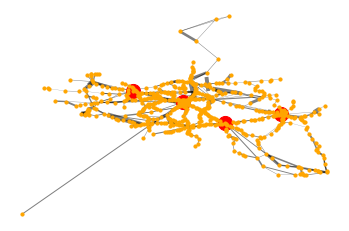

In [11]:
# build the graph
nodes = np.unique(dfedge[['stop1', 'stop2']].values.flatten())
dfnodes = pd.DataFrame(nodes, columns=['stop_id']).merge(dfstops, how='left')
#dfnodes = dfnodes.dropna(subset=['stop_lat']).reset_index(drop=True)
# TODO drop some nan here for lat/lon...
nodes = dfnodes['stop_id']
nodesLoc = np.array([[dfnodes.loc[i, 'stop_lon'], dfnodes.loc[i, 'stop_lat']] for i in range(dfnodes.shape[0])])
nodeNames = dfnodes['stop_name'].values

G = nx.Graph()
for i in range(nodes.shape[0]):
    G.add_node(nodes[i], title=nodeNames[i])

for i in range(dfedge.shape[0]):
    row = dfedge.loc[i, :]
    G.add_edge(row['stop1'], row['stop2'], weight=row['weight'], time=row['time'])

#pos = nx.spring_layout(G)  # positions for all nodes
pos = dict(zip(nodes, nodesLoc))  # position from lat/lon
fig, ax = plt.subplots()
nx.draw_networkx_edges(G, pos, ax=ax, width=dfedge['time']*0.1, alpha=0.5)
nx.draw_networkx_nodes(G, pos, alpha=1, ax=ax, node_color='orange', node_size=10)
#nx.draw_networkx_labels(G, pos, font_family="sans-serif", font_size=8, ax=ax)

# subgraph with some popular stations
G2 = nx.Graph()
stations = ['Namur', 'Bruxelles-Midi', 'Gand-Saint-Pierre', 'Liege-Guillemins']
dfnodes2 = dfnodes[dfnodes['stop_name'].isin(stations)].reset_index(drop=True)
nodes2 = dfnodes2['stop_id']
nodeNames2 = dfnodes2['stop_name']
pos2 = dict(zip(nodeNames2, [nodesLoc[nodeNames == a] for a in nodeNames2]))
for i in range(nodes2.shape[0]):
    G.add_node(nodes2[i], title=nodeNames2[i])
nx.draw_networkx_nodes(G2, pos2, alpha=1, ax=ax, node_color='red', node_size=50)
nx.draw_networkx_labels(G2, pos2, font_family="sans-serif", font_size=8, ax=ax)
ax.scatter(dfnodes2['stop_lon'], dfnodes2['stop_lat'], s=200, c='red')
plt.axis("off")
ax.set_aspect('auto')
#fig.tight_layout()

# need to project lat/lon to UTFM to get a meaningfull plot

In [114]:
nt = Network('100%', '100%', notebook=True)
nt.from_nx(G)
nt.show('belgian-rail.html') # can also open the .html

TypeError: argument of type 'float' is not iterable

In [83]:
# interactive graph
nt = Network('100%', '100%', notebook=True)
nt.from_nx(G)
nt.show_buttons(filter_=['physics'])  # uncomment this line to show the options
nt.set_options("""
var options = {
   "configure": {
        "enabled": false
   },
    "nodes": {
    "font": {
      "size": 25
    }
  },
  "edges": {
    "color": {
      "inherit": true
    },
    "smooth": false
  },
  "physics": {
    "barnesHut": {
      "gravitationalConstant": -15000,
      "springLength": 260,
      "avoidOverlap": 0.4
    },
    "minVelocity": 0.75
  }
}
""")
nt.show('belgian-rail.html') # can also open the .html

In [33]:
dfstops[dfstops['stop_name'].isin(['Namur', 'Bruxelles-Midi']) & dfstops['location_type'].eq(1)]

,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,platform_code
352,S8814001,NaN,Bruxelles-Midi,NaN,50.83571,4.33653,NaN,NaN,1,NaN,NaN
1336,S8863008,NaN,Namur,NaN,50.46879,4.86222,NaN,NaN,1,NaN,NaN


In [12]:
# routing between two points
stopA = 'Gand-Saint-Pierre'
stopB = 'Mont-Saint-Guibert'
stop_idA = dfstops[dfstops['stop_name'].eq(stopA) & dfstops['location_type'].eq(1)]['stop_id'].values[0]
stop_idB = dfstops[dfstops['stop_name'].eq(stopB) & dfstops['location_type'].eq(1)]['stop_id'].values[0]
intnodes = nx.shortest_path(G, stop_idA[1:], stop_idB[1:], weight='time')
travelTime = nx.shortest_path_length(G, stop_idA[1:], stop_idB[1:], weight='time')
print('FROM: {:s} ({:s}) TO {:s} ({:s}): {:.0f} minutes by {:s}'.format(
    stopA, stop_idA, stopB, stop_idB, travelTime, ', '.join(node2name(intnodes))))
# intnodes = nx.all_shortest_paths(G, stop_idA[1:], stop_idB[1:], weight='weight')
# for g in intnodes:
#     print(g)

FROM: Gand-Saint-Pierre (S8892007) TO Mont-Saint-Guibert (S8861549): 81 minutes by Gand-Saint-Pierre, Bruxelles-Midi, Bruxelles-Schuman, Bruxelles-Luxembourg, Ottignies, Mont-Saint-Guibert


In [23]:
# using the network we look for the shortest path between A and B
stopA = 'Gand-Saint-Pierre'  # from which to draw the isochrone
stop_idA = dfstops[dfstops['stop_name'].eq(stopA) & dfstops['location_type'].eq(1)]['stop_id'].values[0]
other_stop_ids = dfstops[dfstops['stop_id'].ne(stop_idA)]['stop_id']

# compute the time from all (or a subselection) of stations
stops = []
times = []
errors = []
for stop_id in tqdm(other_stop_ids):
    try:
        travelTime = nx.shortest_path_length(G, stop_idA[1:], stop_id[1:], weight='time')
        stops.append(stop_id[1:])
        times.append(travelTime)
    except Exception as e:
        errors.append(e)
dfiso = pd.DataFrame()
dfiso['stop_id'] = stops
dfiso['travel_time'] = np.round(times, 0)
dfiso['stopA'] = stop_idA[1:]
dfiso = dfiso.merge(dfstops, how='left')
dfiso.to_csv(datadir + 'dfiso.csv', index=False)
dfiso

100%|█████████████████████████████████████████████████████████████████████████████| 2642/2642 [00:04<00:00, 632.24it/s]


,stop_id,travel_time,stopA,stop_code,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,platform_code
0,8811007,50.0,8892007,NaN,Schaerbeek,NaN,50.87851,4.378640,NaN,NaN,0,S8811007,NaN
1,8811106,59.0,8892007,NaN,Evere,NaN,50.86778,4.400963,NaN,NaN,0,S8811106,NaN
2,8811130,54.0,8892007,NaN,Haren-Sud,NaN,50.88969,4.415358,NaN,NaN,0,S8811130,NaN
3,8811148,54.0,8892007,NaN,Buda,NaN,50.90750,4.417075,NaN,NaN,0,S8811148,NaN
4,8811155,61.0,8892007,NaN,Haren,NaN,50.88888,4.419980,NaN,NaN,0,S8811155,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
548,8896503,70.0,8892007,NaN,Ypres,NaN,50.84740,2.876590,NaN,NaN,0,S8896503,NaN
549,8896735,79.0,8892007,NaN,Poperinge,NaN,50.85445,2.736345,NaN,NaN,0,S8896735,NaN
550,8896800,47.0,8892007,NaN,Roulers,NaN,50.94903,3.130415,NaN,NaN,0,S8896800,NaN
551,8896909,44.0,8892007,NaN,Izegem,NaN,50.92115,3.212089,NaN,NaN,0,S8896909,NaN


In [167]:
dfiso[dfiso['stop_name'].isin(['Rhisnes', 'Namur', 'Gembloux', 'Beuzet'])]

,stop_id,travel_time,stopA,stop_code,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,platform_code
261,8861200,87.849656,8892007,NaN,Gembloux,NaN,50.57048,4.691497,NaN,NaN,0,S8861200,NaN
265,8861424,95.312342,8892007,NaN,Beuzet,NaN,50.53421,4.748531,NaN,NaN,0,S8861424,NaN
267,8861440,101.789954,8892007,NaN,Rhisnes,NaN,50.49935,4.801870,NaN,NaN,0,S8861440,NaN
273,8863008,96.434833,8892007,NaN,Namur,NaN,50.46879,4.862220,NaN,NaN,0,S8863008,NaN


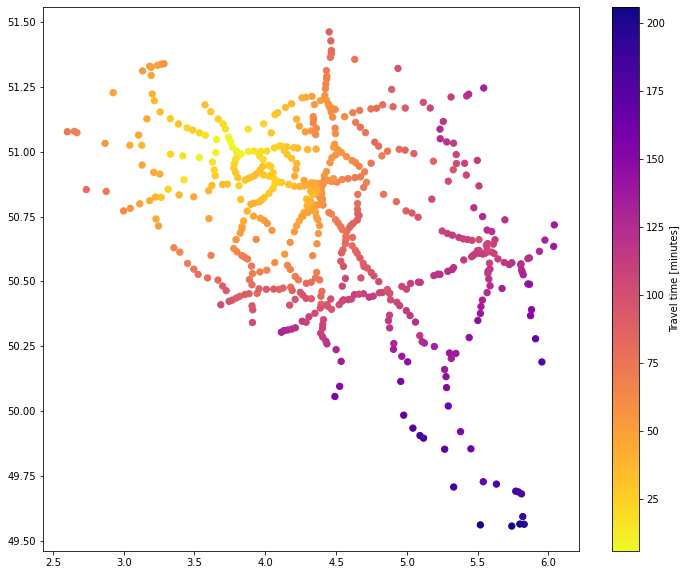

In [14]:
# simple figure
fig, ax = plt.subplots(figsize=(12, 10))
# stopA lat and lon
cax = ax.scatter(dfiso['stop_lon'], dfiso['stop_lat'], s=40, c=dfiso['travel_time'], cmap='plasma_r')
fig.colorbar(cax, ax=ax, label='Travel time [minutes]')

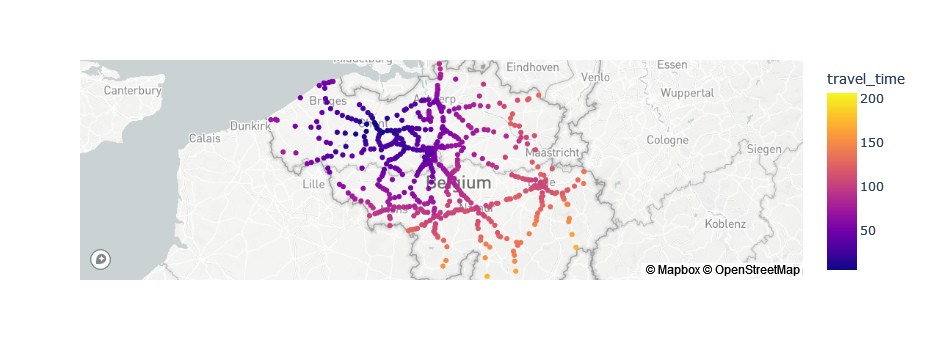

In [29]:
# simple figure
px.set_mapbox_access_token('pk.eyJ1Ijoic2FnaXR0YTE2MTgiLCJhIjoiY2t4MHh6cjZvMDZxODJ2cnpzbGwzN2hqaCJ9.SqrherbackzNotZqAlFA6Q')
fig = px.scatter_mapbox(dfiso, 'stop_lat', 'stop_lon', color='travel_time', zoom=6)
fig

In [ ]:
# here we can build an isochrone by computing shortest path (in time) from a unique node to other nodes
# and then we plot it on the map (contouring is not so good)

In [ ]:
# for querying a route between A and B:
# using the intermediate nodes we check for the next node if it's still in the current trip
# if not, we go back to the previous node and check it's a transfer node (go back further if needed)
# we then find the closest trip (in time) that match the next node. a connection is made